In [2]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F  
import matplotlib 
import matplotlib.pyplot as plt

In [3]:
EPSILON = 0.05       # Max perturbation (for L∞ PGD)
ALPHA = 0.01         # Step size per iteration
ATTACK_ITERATIONS = 20
TARGET_LABEL = 3     # Example target label for the targeted attack

# System/Model parameters
sys.path.append("/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12_largerInput.pth"
#IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_1m_run0.iq"  # Example file
IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_2m_run0.iq"



In [4]:
from attempt2 import resnet50_1d  # Directly import from attempt2.py
num_classes = 8  # Change this if your model was trained with a different number of classes

# Initialize the model architecture
model = resnet50_1d(num_classes=num_classes).to(DEVICE)

# Load trained weights
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12.pth"
print(f"Loading trained model weights from: {MODEL_PATH}")
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

Loading trained model weights from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12.pth


/tmp/ipykernel_512133/1761318717.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck1D(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

In [5]:
def load_iq_data(file_path, max_samples=4096*2, start_idx=0):
    """
    Loads a limited portion of `.iq` data.
    
    Args:
        file_path (str): Path to the `.iq` file.
        max_samples (int): The number of samples to load.
        start_idx (int): The starting index to read from.

    Returns:
        data_tensor (torch.Tensor): shape [1, 2, max_samples]
        label_tensor (torch.Tensor): Dummy label for testing.
    """
    total_samples = max_samples * 2  # Since I/Q samples are interleaved

    #  Open the file in binary mode and seek to `start_idx`
    with open(file_path, "rb") as f:
        f.seek(start_idx * 4 * 2)  # 4 bytes per float32, 2 channels (I/Q)
        raw_data = np.fromfile(f, dtype="float32", count=total_samples)

    #  Ensure we have enough data
    if raw_data.shape[0] < total_samples:
        raise ValueError(f"Not enough data in {file_path}. Requested {total_samples}, got {raw_data.shape[0]}.")

    #  Extract I/Q channels
    I = raw_data[0::2]  # Even indices
    Q = raw_data[1::2]  # Odd indices

    #  Stack into [2, max_samples] format
    iq_data = np.stack([I, Q], axis=0)

    #  Add batch dimension → [1, 2, max_samples]
    iq_data = np.expand_dims(iq_data, axis=0)

    #  Convert to PyTorch tensor
    data_tensor = torch.from_numpy(iq_data).float()

    #  Dummy label for now (adjust if needed)
    label_tensor = torch.tensor([0], dtype=torch.long)

    return data_tensor, label_tensor

In [17]:
def targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter):

    model.eval()
    
    if isinstance(target_label, int):
        target_label = torch.full_like(y, target_label)
    
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True

    for _ in range(num_iter):
        outputs = model(x_adv)
        
        loss = -nn.CrossEntropyLoss()(outputs, target_label)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.data
        x_adv = x_adv.detach() + alpha * grad.sign()

        x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)

        x_adv.requires_grad = True

    return x_adv.detach()


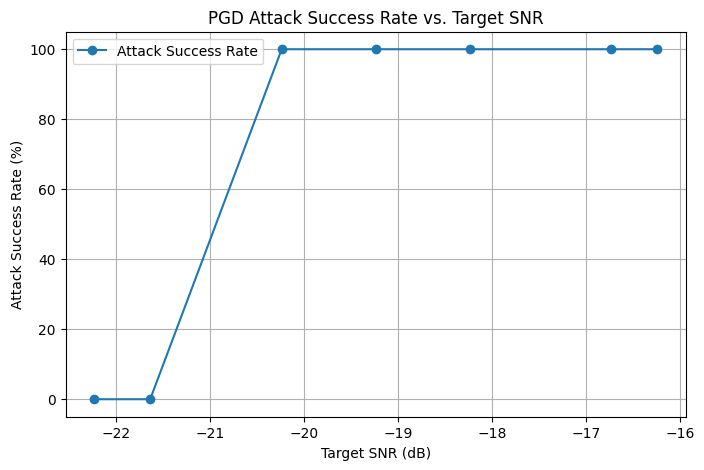

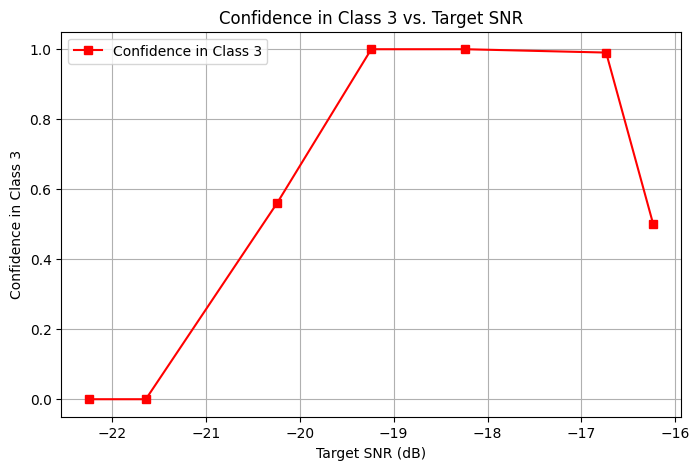

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_power(tensor):
    return torch.mean(tensor ** 2)

def compute_unscaled_snr(x, x_adv):
    perturbation = x_adv - x
    P_signal = compute_power(x)
    P_noise = compute_power(perturbation)
    snr = 10 * torch.log10(P_signal / P_noise)
    return snr.item(), P_signal, P_noise

def scale_perturbation(x, x_adv, target_snr_db, P_signal, P_noise_current):
    P_noise_desired = P_signal / (10 ** (target_snr_db / 10))
    scale_factor = torch.sqrt(P_noise_desired / P_noise_current)
    x_adv_scaled = x + scale_factor * (x_adv - x)
    return x_adv_scaled

def evaluate_attack(model, x, y, target_label, eps, alpha, num_iter, target_snr_db, P_signal, P_noise_current):
    x_adv = targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter)
    unscaled_snr, _, _ = compute_unscaled_snr(x, x_adv)
    model.eval()
    with torch.no_grad():
        logits_unscaled = model(x_adv)
        probs_unscaled = F.softmax(logits_unscaled, dim=1)
        pred_unscaled = torch.argmax(probs_unscaled, dim=1)
    
    x_adv_scaled = scale_perturbation(x, x_adv, target_snr_db, P_signal, P_noise_current)
    
    with torch.no_grad():
        logits_scaled = model(x_adv_scaled)
        probs_scaled = F.softmax(logits_scaled, dim=1)
        pred_scaled = torch.argmax(probs_scaled, dim=1)
    
    if isinstance(target_label, int):
        target_tensor = torch.tensor([target_label], device=x.device)
    else:
        target_tensor = target_label.to(x.device)
    
    success = (pred_scaled == target_tensor).item()
    confidence_class_3 = probs_scaled[:, 3].item()
    
    return success, confidence_class_3

def run_evaluation(model, x, y, target_label, eps, alpha, num_iter, snr_offsets, num_trials=10):
    x_adv_sample = targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter)
    unscaled_snr, P_signal, P_noise_current = compute_unscaled_snr(x, x_adv_sample)
    
    snr_values = [unscaled_snr + offset for offset in snr_offsets]
    success_rates = []
    confidences = []
    
    for target_snr in snr_values:
        successes = 0
        confidence_scores = []
        for _ in range(num_trials):
            success, confidence_class_3 = evaluate_attack(model, x, y, target_label, eps, alpha, num_iter, target_snr, P_signal, P_noise_current)
            successes += success
            confidence_scores.append(confidence_class_3)
        success_rate = successes / num_trials * 100
        avg_confidence = np.mean(confidence_scores)
        success_rates.append(success_rate)
        confidences.append(avg_confidence)
    
    return snr_values, success_rates, confidences

EPSILON = 0.1
ALPHA = 0.01
ATTACK_ITERATIONS = 40
TARGET_LABEL = 3
snr_offsets = [-3, -2.4, -1, 0, 1, 2.5, 3]

data, labels = load_iq_data(IQ_FILE_PATH)
data, labels = data.to(DEVICE), labels.to(DEVICE)

snr_values, success_rates, confidences = run_evaluation(model, data, labels, TARGET_LABEL, EPSILON, ALPHA, ATTACK_ITERATIONS, snr_offsets, num_trials=10)

plt.figure(figsize=(8, 5))
plt.plot(snr_values, success_rates, marker='o', label='Attack Success Rate')
plt.xlabel("Target SNR (dB)")
plt.ylabel("Attack Success Rate (%)")
plt.title("PGD Attack Success Rate vs. Target SNR")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(snr_values, confidences, marker='s', color='red', label='Confidence in Class 3')
plt.xlabel("Target SNR (dB)")
plt.ylabel("Confidence in Class 3")
plt.title("Confidence in Class 3 vs. Target SNR")
plt.grid(True)
plt.legend()
plt.show()


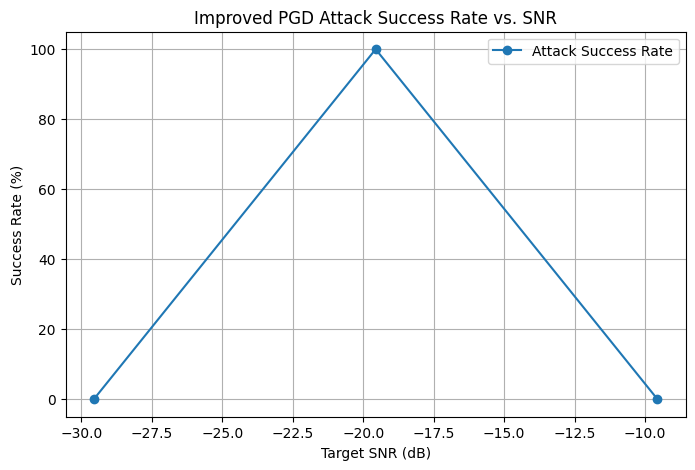

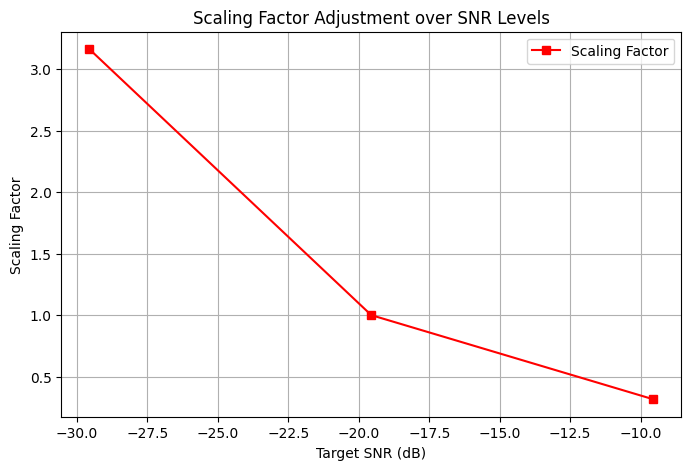

In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_power(tensor):
    return torch.mean(tensor ** 2)

def compute_unscaled_snr(x, x_adv):
    perturbation = x_adv - x
    P_signal = compute_power(x)
    P_noise = compute_power(perturbation)
    snr = 10 * torch.log10(P_signal / P_noise)
    return snr.item(), P_signal, P_noise

def targeted_pgd_attack_robust(model, x, y, target_label, eps, alpha, num_iter, adaptive_noise_factor=0.1):
    model.eval()
    if isinstance(target_label, int):
        target_label = torch.full_like(y, target_label)
    
    x_adv = x.clone().detach().to(x.device)
    x_adv.requires_grad = True
    
    for i in range(num_iter):
        outputs = model(x_adv)
        loss = -F.cross_entropy(outputs, target_label)
        model.zero_grad()
        loss.backward()
        
        grad = x_adv.grad.data
        noise = alpha * grad.sign()
        noise = noise * (1 + adaptive_noise_factor * (i / num_iter))  # Gradually increase perturbation strength
        
        x_adv = x_adv.detach() + noise
        x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)
        x_adv.requires_grad = True
    
    return x_adv.detach()

def scale_perturbation_adaptive(x, x_adv, target_snr_db, P_signal, P_noise_current):
    P_noise_desired = P_signal / (10 ** (target_snr_db / 10))
    scale_factor = torch.sqrt(P_noise_desired / P_noise_current)
    x_adv_scaled = x + scale_factor * (x_adv - x)
    return x_adv_scaled, scale_factor

def evaluate_attack_adaptive(model, x, y, target_label, eps, alpha, num_iter, target_snr_db, P_signal, P_noise_current):
    x_adv = targeted_pgd_attack_robust(model, x, y, target_label, eps, alpha, num_iter)
    unscaled_snr, _, _ = compute_unscaled_snr(x, x_adv)
    
    with torch.no_grad():
        logits_unscaled = model(x_adv)
        probs_unscaled = F.softmax(logits_unscaled, dim=1)
        pred_unscaled = torch.argmax(probs_unscaled, dim=1)
    
    x_adv_scaled, scale_factor = scale_perturbation_adaptive(x, x_adv, target_snr_db, P_signal, P_noise_current)
    
    with torch.no_grad():
        logits_scaled = model(x_adv_scaled)
        probs_scaled = F.softmax(logits_scaled, dim=1)
        pred_scaled = torch.argmax(probs_scaled, dim=1)
    
    target_tensor = torch.tensor([target_label], device=x.device) if isinstance(target_label, int) else target_label.to(x.device)
    success = (pred_scaled == target_tensor).item()
    return success, scale_factor.item()

def run_adaptive_evaluation(model, x, y, target_label, eps, alpha, num_iter, snr_offsets, num_trials=10):
    x_adv_sample = targeted_pgd_attack_robust(model, x, y, target_label, eps, alpha, num_iter)
    unscaled_snr, P_signal, P_noise_current = compute_unscaled_snr(x, x_adv_sample)
    
    snr_values = [unscaled_snr + offset for offset in snr_offsets]
    success_rates = []
    scale_factors = []
    
    for target_snr in snr_values:
        successes = 0
        scales = []
        for _ in range(num_trials):
            success, scale_factor = evaluate_attack_adaptive(model, x, y, target_label, eps, alpha, num_iter, target_snr, P_signal, P_noise_current)
            successes += success
            scales.append(scale_factor)
        success_rate = successes / num_trials * 100
        success_rates.append(success_rate)
        scale_factors.append(np.mean(scales))
    
    return snr_values, success_rates, scale_factors

EPSILON = 0.1
ALPHA = 0.01
ATTACK_ITERATIONS = 40
TARGET_LABEL = 3

snr_offsets = [-10, 0, 10]

data, labels = load_iq_data(IQ_FILE_PATH)
data, labels = data.to(DEVICE), labels.to(DEVICE)

snr_values, success_rates, scale_factors = run_adaptive_evaluation(model, data, labels, TARGET_LABEL, EPSILON, ALPHA, ATTACK_ITERATIONS, snr_offsets, num_trials=10)

plt.figure(figsize=(8, 5))
plt.plot(snr_values, success_rates, marker='o', label='Attack Success Rate')
plt.xlabel("Target SNR (dB)")
plt.ylabel("Success Rate (%)")
plt.title("Improved PGD Attack Success Rate vs. SNR")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(snr_values, scale_factors, marker='s', color='red', label='Scaling Factor')
plt.xlabel("Target SNR (dB)")
plt.ylabel("Scaling Factor")
plt.title("Scaling Factor Adjustment over SNR Levels")
plt.grid(True)
plt.legend()
plt.show()